In [1]:
from lusidtools.jupyter_tools import toggle_code
from IPython.core.display import HTML

""" Creating portfolios with different tax lot management methods

This notebook demonstrates how to create transaction portfolios under different tax lot accounting methodologies.

Attributes
----------
transactions
holdings
taxlots
accounting
corporate actions
"""

toggle_code("Toggle Docstring")

# Tax Lot Management

Contents: 

* [1. Initial Setup](#1.-Initial-Setup)
* [2. Loading our Data](#2.-Loading-our-Data)
    * [2.1 Create Portfolio](#2.1-Create-Portfolio)
    * [2.2 Create Instruments](#2.2-Create-Instruments)
    * [2.3 Upload Transactions](#2.3-Upload-Transactions)
* [3. Cost Basis Comparison](#3.-Cost-Basis-Comparison)
    * [3.1 Average Cost](#3.1-Average-Cost)
    * [3.2 First In First Out](#3.2-First-In-First-Out-(FIFO)) 
    * [3.3 Last In Last Out](#3.3-Last-In-Last-Out-(LIFO))
    * [3.4 Highest First](#3.4-Highest-First) 
    * [3.5 Lowest First](#3.5-Lowest-First)
* [4. Corporate Actions](#4.-Corporate-Actions)
* [5. Demo Walkthrough](#5.-Demo-Walkthrough)
* [6. Backdating](#6.-Backdating)
    * [6.1 Closed Book Positions](#6.1-Closed-Book-Positions)
    * [6.2 Backdated Activity](#6.2-Backdated-Activity)
    * [6.3 Backdated Sale](#6.3-Backdated-Sale)
    * [6.4 Effect on Corporate Actions](#6.4-Effect-on-Corporate-Actions)
    * [6.5 Backdated Price Correction](#6.5-Backdated-Price-Correction)


Portfolios in LUSID can be created using any of the following tax lot accounting methods:
- Average Cost (default in LUSID)
- First In First Out (FIFO)
- Last In First Out (LIFO)
- Lowest Cost First
- Highest Cost First

These will determine how tax lots are used to update the cost basis of a transaction portfolio when booking various transactions.
Helpful KB articles:
- [What are the supported tax-lot accounting methods in LUSID?](https://support.lusid.com/knowledgebase/article/KA-01886/en-us)
- [How do I handle different tax lot accounting conventions?](https://support.lusid.com/knowledgebase/article/KA-01887/en-us)

## 1. Initial Setup<a name="initialsetup"></a>
This section will set up the parameters and methods used in section 2, to compare accounting methods.

In [2]:
# Import LUSID
import lusid
import lusid.models as models
import pandas as pd
from IPython.core.display import HTML

# Import Libraries
import matplotlib.pyplot as plt
import pytz
from lusidjam import RefreshingToken
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.cocoon import load_from_data_frame
from lusidtools.cocoon.cocoon_printer import CocoonPrinter
import json
import os
from datetime import datetime
from dateutil.parser import parse
from enum import Enum
from datetime import timedelta

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

pd.set_option('display.float_format', lambda x: f'{x:,.1f}')

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

print('LUSID Environment Initialised')
print('LUSID version : ', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

LUSID Environment Initialised
LUSID version :  0.6.11682.0


In [3]:
# Create necessary API factories
transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)
derived_portfolios_api = api_factory.build(lusid.api.DerivedTransactionPortfoliosApi)
property_definitions_api = api_factory.build(lusid.api.PropertyDefinitionsApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
corporate_action_sources_api = api_factory.build(lusid.api.CorporateActionSourcesApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
recipes_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
recipes_api = api_factory.build(lusid.api.ConfigurationRecipeApi)

### Variables

In [4]:
scope = "taxlot_management_examplenb"
ca_code = "tax_lot_stock_split"
recipe_code = "valuation"
txns = pd.read_csv("data/taxlot_accounting_transactions.csv",parse_dates=['transaction_date','settlement_date'], date_parser = lambda x : parse(x).strftime('%Y-%m-%d'))

### Data Clean Up

In [5]:
# Delete Corporate Action Source & Action
try:
    resp = corporate_action_sources_api.delete_corporate_action_source(
        scope=scope,
        code=ca_code
    )
    if resp:
        print(f"DELETED: Corporate Actions Source '{scope}/{ca_code}'")
except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

# Delete Configuration Recipe
try:
    resp = recipes_api.delete_configuration_recipe(scope=scope, code=recipe_code)
    if resp:
        print(f"DELETED: Configuration Recipe '{scope}/{recipe_code}'")
except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

# Delete Properties
try:
    resp = property_definitions_api.delete_property_definition(
        domain="Transaction",
        scope=scope,
        code="sleeve"
    )
    if resp:
        print(f"DELETED: Property 'Transaction/{scope}/sleeve'")
except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

# Delete Portfolios
for code in ["tax-lot-fifo", "tax-lot-lifo", "tax-lot-highestcost", "tax-lot-lowestcost", "tax-lot-avgcost"]:
    try:
        resp = portfolios_api.delete_portfolio(
            scope=scope,
            code=code
        )
        if resp:
            print(f"DELETED: Portfolio '{code}'")
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

        
# Delete Quotes
quotes = quotes_api.list_quotes_for_scope(scope)
if len(quotes.values) > 0:
    quotes_api.delete_quotes(
        scope, 
        request_body={
            f"{quote.quote_id.quote_series_id.instrument_id}_{quote.as_at}": quote.quote_id
            for quote in quotes.values
        }
    )
    print (f"DELETED: {len(quotes.values)} quotes")

instruments = [client_id for client_id in txns["client_internal"].unique() if not client_id.startswith("CASH")]
# Delete Instruments
luids_to_delete = []

for client_id in instruments:
    
    try:
        luids_to_delete.append(instruments_api.get_instrument("ClientInternal", client_id).lusid_instrument_id)
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

if len(luids_to_delete) > 0:
    try:
        resp = instruments_api.delete_instruments(
            request_body=luids_to_delete,
            delete_mode='Hard'
        )
        if resp:
            print(f"DELETED: Instruments '{luids_to_delete}'")
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

DELETED: Corporate Actions Source 'taxlot_management_examplenb/tax_lot_stock_split'
DELETED: Configuration Recipe 'taxlot_management_examplenb/valuation'
DELETED: Property 'Transaction/taxlot_management_examplenb/sleeve'
DELETED: Portfolio 'tax-lot-fifo'
DELETED: Portfolio 'tax-lot-lifo'
DELETED: Portfolio 'tax-lot-highestcost'
DELETED: Portfolio 'tax-lot-lowestcost'
DELETED: Portfolio 'tax-lot-avgcost'
DELETED: 6 quotes
DELETED: Instruments '['LUID_0000PBBD', 'LUID_0000PBBG', 'LUID_0000PBBF', 'LUID_0000PBBB', 'LUID_0000PBBC', 'LUID_0000PBBE']'


# 2. Loading our Data<a name = "loading-our-data"></a>

In [6]:
# Specify scope and load data
txns.head()

,transaction_id,type,units,transaction_price,transaction_date,settlement_date,total_consideration,client_internal,ticker,name,sleeve,trade_to_portfolio_rate
0,txn_000,FundsIn,"80,000,000",1.0,2020-03-04,2020-03-05,"80,000,000",CASH_USD,USD,Cash USD,Sleeve 1,0.8
1,txn_001,FundsIn,"95,000,000",1.0,2020-03-04,2020-03-05,"95,000,000",CASH_USD,USD,Cash USD,Sleeve 2,0.8
2,txn_002,Buy,"100,000",167.6,2020-03-05,2020-03-08,"16,763,000",EQUITY_APPL,AAPL,Apple,Sleeve 1,0.8
3,txn_003,Buy,"100,000",163.0,2020-03-06,2020-03-09,"16,298,000",EQUITY_APPL,AAPL,Apple,Sleeve 1,0.8
4,txn_004,Buy,"100,000",165.4,2020-03-07,2020-03-10,"16,542,000",EQUITY_APPL,AAPL,Apple,Sleeve 1,0.8


## 2.1 Create Portfolio<a name = "create-portfolio"></a>
When creating a transaction portfolio in LUSID, we pass in a parameter of the `accounting_method` to determine how the tax lots are calculated. If not specified, **Average Cost** is the default method used in LUSID.

In [7]:
# Create corporate action source, this is covered further in section 4
try:

    source_request = models.CreateCorporateActionSourceRequest(
        scope=scope,
        code=ca_code,
        display_name="Tax Lot Corporate Action Source",
        description="Corporate Actions source for tax lot sample notebook",
    )

    corporate_action_sources_api.create_corporate_action_source(
        create_corporate_action_source_request=source_request
    )

except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

In [8]:
# Create sleeve property for sub-holding key
try:
    resp = property_definitions_api.create_property_definition(
        create_property_definition_request=models.CreatePropertyDefinitionRequest(
            domain="Transaction",
            scope=scope,
            code="sleeve",
            value_required=None,
            display_name="Sleeve",
            data_type_id=models.ResourceId(scope="system", code="string"),
            life_time=None,
        )
    )
    print(f"{resp.key} property created")
    
except lusid.ApiException as e:
    if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

Transaction/taxlot_management_examplenb/sleeve property created


In [9]:
def create_upload_portfolio(name, accounting_method):
    try:
        created_date = "2010-01-01T00:00:00.000000+00:00"

        # Create request body
        portfolio_request = models.CreateTransactionPortfolioRequest(
            display_name=f"Tax Lot Management Example - {accounting_method}",
            code=name,
            base_currency="GBP",
            corporate_action_source_id=lusid.ResourceId(scope=scope, code=ca_code),
            accounting_method=accounting_method, # If not specified - AverageCost is the default accounting method.
            created=created_date,
            sub_holding_keys=[f"Transaction/{scope}/sleeve"],
        )

        # Upload new portfolio to LUSID
        response = transaction_portfolios_api.create_portfolio(
            scope=scope, create_transaction_portfolio_request=portfolio_request
        )

        created = response.version.effective_from
        print(
        f"Portfolio '{response.id.code}', in scope {scope} created effective from: "
        f"{created.year}/"
        f"{created.month}/"
        f"{created.day}")
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

In [10]:
def create_derived_portfolio(portfolio_code, parent_code, accounting_method, ca_code):
    try:
        derived_portfolio_request = models.CreateDerivedTransactionPortfolioRequest(
            display_name=f"Tax Lot Management Example - {accounting_method}",
            code=portfolio_code,
            parent_portfolio_id=models.ResourceId(scope=scope, code= parent_code),
            created="2020-01-01",
            corporate_action_source_id=lusid.ResourceId(scope=scope, code=ca_code),
            accounting_method=accounting_method,
            sub_holding_keys=[f"Transaction/{scope}/sleeve"],
        )
        response = derived_portfolios_api.create_derived_portfolio(
            scope=scope,
            create_derived_transaction_portfolio_request = derived_portfolio_request)
        created = response.version.effective_from
        print(
        f"Derived portfolio '{response.id.code}', in scope {scope} created effective from: "
        f"{created.year}/"
        f"{created.month}/"
        f"{created.day}")

    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

In [11]:
# Create a parent portfolio.
portfolio_name_avg = "tax-lot-avgcost"
create_upload_portfolio(portfolio_name_avg, "AverageCost")

Portfolio 'tax-lot-avgcost', in scope taxlot_management_examplenb created effective from: 2010/1/1


In [12]:
# Create portfolios derived from the AverageCost portfolio. (Tax lot type of the parent portfolio does not affect the derived
# portfolios.)
portfolio_name_fifo = "tax-lot-fifo"
create_derived_portfolio(portfolio_name_fifo, portfolio_name_avg, "FirstInFirstOut", ca_code)

portfolio_name_lifo = "tax-lot-lifo"
create_derived_portfolio(portfolio_name_lifo, portfolio_name_avg, "LastInFirstOut", ca_code)

portfolio_name_high = "tax-lot-highestcost"
create_derived_portfolio(portfolio_name_high, portfolio_name_avg, "HighestCostFirst", ca_code)

portfolio_name_low = "tax-lot-lowestcost"
create_derived_portfolio(portfolio_name_low, portfolio_name_avg, "LowestCostFirst", ca_code)

Derived portfolio 'tax-lot-fifo', in scope taxlot_management_examplenb created effective from: 2010/1/1
Derived portfolio 'tax-lot-lifo', in scope taxlot_management_examplenb created effective from: 2010/1/1
Derived portfolio 'tax-lot-highestcost', in scope taxlot_management_examplenb created effective from: 2010/1/1
Derived portfolio 'tax-lot-lowestcost', in scope taxlot_management_examplenb created effective from: 2010/1/1


## 2.2 Create Instruments<a name = "create-instruments"></a>

In [13]:
# Create instruments
batch_upsert_request = {}
uploaded = []

for index, row in txns.iterrows():
    client_internal = row['client_internal']
    ticker = row['ticker']
    name = row['name']
    
    if client_internal.startswith("CASH") or client_internal in uploaded:
        continue
    else:
        batch_upsert_request[client_internal] = models.InstrumentDefinition(
            name=name,
            identifiers={ 
                "ClientInternal": models.InstrumentIdValue(value=client_internal),
                "Ticker": models.InstrumentIdValue(value=ticker)
            },
            definition=models.Equity(
                instrument_type="Equity",
                dom_ccy="USD"
            )
        )
        uploaded.append(client_internal)
        

# Upsert new instruments to LUSID
instrument_response = instruments_api.upsert_instruments(
    request_body=batch_upsert_request
)

# Check response was successful
if len(instrument_response.failed) > 0:
    raise AssertionError("Instruments upsert failed. Inspect response for more detail")
    
print(f"{len(instrument_response.values)} instruments uploaded")

6 instruments uploaded


## 2.3 Upload Transactions<a name = "upload-transactions"></a>

In [14]:
def upload_transactions_to_portfolio(portfolio_name, transactions):
    # Upsert transactions
    transactions_request = []

    for index, row in transactions.iterrows():

        if row["client_internal"].startswith("CASH"):
            instrument_identifier = {"Instrument/default/Currency": "USD"}

        else:
            instrument_identifier = {
                    "Instrument/default/ClientInternal": row["client_internal"]
                }

        # Build request body
        transactions_request.append(
            models.TransactionRequest(
                transaction_id=row["transaction_id"],
                type=row["type"],
                instrument_identifiers=instrument_identifier,
                transaction_date=row["transaction_date"].isoformat() + "Z",
                settlement_date=row["settlement_date"].isoformat() + "Z",
                units=row["units"],
                transaction_price=models.TransactionPrice(price=row["transaction_price"], type="Price"),
                total_consideration=models.CurrencyAndAmount(
                    amount=row["total_consideration"], currency="USD"
                ),
                properties={
                    f"Transaction/{scope}/sleeve": 
                    models.PerpetualProperty(
                        key=f"Transaction/{scope}/sleeve",
                        value=models.PropertyValue(label_value=row['sleeve'])
                    ),
                    f"Transaction/default/TradeToPortfolioRate": 
                    models.PerpetualProperty(
                        key=f"Transaction/default/TradeToPortfolioRate",
                        value=models.PropertyValue(
                            metric_value=models.MetricValue(value=row["trade_to_portfolio_rate"])
                        )
                    )
                }
            )
        )

    # Make upsert transactions call to LUSID
    txn_response = transaction_portfolios_api.upsert_transactions(
            scope=scope, code=portfolio_name, transaction_request=transactions_request
    )

    print(f"{len(transactions_request)} transactions upserted to portfolio: {portfolio_name}")
    
    return txn_response

In [15]:
# Upload transactions to parent portfolio. The transactions will be automatically added to the derived portfolios.
original_transactions_response = upload_transactions_to_portfolio(portfolio_name_avg, txns)

28 transactions upserted to portfolio: tax-lot-avgcost


In [16]:
# Show transactions in chronological order
txns.sort_values('transaction_date',ascending=True).head()

,transaction_id,type,units,transaction_price,transaction_date,settlement_date,total_consideration,client_internal,ticker,name,sleeve,trade_to_portfolio_rate
0,txn_000,FundsIn,"80,000,000",1.0,2020-03-04,2020-03-05,"80,000,000",CASH_USD,USD,Cash USD,Sleeve 1,0.8
1,txn_001,FundsIn,"95,000,000",1.0,2020-03-04,2020-03-05,"95,000,000",CASH_USD,USD,Cash USD,Sleeve 2,0.8
6,txn_006,Buy,"70,000",288.4,2020-03-04,2020-03-08,"20,191,500",EQUITY_MSFT,MSFT,Microsoft,Sleeve 2,0.8
18,txn_018,Buy,"25,000",162.5,2020-03-05,2020-03-08,"4,063,250",EQUITY_JNJ,JNJ,Johnson & Johnson,Sleeve 1,0.8
14,txn_014,Buy,"18,000",279.3,2020-03-05,2020-03-08,"5,027,580",EQUITY_NVDA,NVDA,NVIDIA,Sleeve 2,0.8


# 3. Cost Basis Comparison<a name = "cost-basis-comp"></a>
Holdings before our sell transaction show the three distinct tax lots and corresponding transactions. We can see that each tax lot has a distinct cost basis based on the transaction price and total consideration of each transaction.

When calling `get_holdings()` in the `display_holding_positions_by_taxlot` method, setting the flag `by_taxlots=true` returns the holdings separated by tax lots, as shown below.

In [17]:
# Prints quick summary from a get_holdings() response of positions for a given effective_at date broken down by tax lots
def display_holding_positions_by_taxlot(effective_at, portfolio_name, show_taxlots = True, as_at = None):
    # Get holdings
    response = transaction_portfolios_api.get_holdings(
        scope=scope,
        code=portfolio_name,
        effective_at = effective_at.isoformat(),
        as_at = as_at,
        property_keys=["Instrument/default/Name"],
        by_taxlots=show_taxlots
    )

    # Inspect holdings response for the given effective_at day
    hld = [i for i in response.values]

    names = []
    cost = []
    units = []
    txnid = []
    pchprice = []
    pchdate = []

    for item in hld:
        if item.holding_type_name == "Position":
            names.append(item.properties["Instrument/default/Name"].value.label_value)
            cost.append(item.cost.amount)
            units.append(item.units)
            if show_taxlots:
                txnid.append(item.properties["Holding/default/TaxlotId"].value.label_value)
                pchprice.append(item.properties["Holding/default/TaxlotPurchasePrice"].value.metric_value.value)
                pchdate.append(item.properties["Holding/default/TaxlotPurchaseDate"].value.label_value.replace("T00:00:00.0000000+00:00",""))
                
    data = {"cost_basis": cost, "units": units}
    if show_taxlots:
        data = {"transaction_id": txnid, **data , "purchase_price":pchprice, "purchase_date":pchdate}
    return pd.DataFrame(data=data, index=names)

In [18]:
# Displays a link to view portfolio in LUSID
def print_url_to_holdings(effective_at, portfolio_name):
    date = effective_at.strftime('%Y-%m-%d')
    api_url = api_factory.api_client.configuration._base_path.replace("api","")
    display(HTML(f'<a href="{api_url}app/dashboard/holdings?scope=taxlot_management_examplenb&code={portfolio_name}&entityType=Portfolio&taxLots=true&effectiveDate={date}" target="_blank">See holdings positions by tax lot in LUSID</a>'))

In [19]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_fifo)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_006,"20,191,500.0","70,000.0",288.4,2020-03-04
Microsoft,txn_007,"19,903,800.0","70,000.0",284.3,2020-03-05
Microsoft,txn_008,"9,816,100.0","70,000.0",140.2,2020-03-07
Apple,txn_002,"16,763,000.0","100,000.0",167.6,2020-03-05
Apple,txn_003,"16,298,000.0","100,000.0",163.0,2020-03-06
Apple,txn_004,"16,542,000.0","100,000.0",165.4,2020-03-07
Berkshire Hathaway,txn_010,"3,230,900.0","10,000.0",323.1,2020-03-05
Berkshire Hathaway,txn_011,"3,202,000.0","10,000.0",320.2,2020-03-06
Berkshire Hathaway,txn_012,"3,256,800.0","10,000.0",325.7,2020-03-07
NVIDIA,txn_014,"5,027,580.0","18,000.0",279.3,2020-03-05


In [20]:
print_url_to_holdings(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_fifo)

We'll now look at the final positions of our portfolios under the 5 accounting methods described above. The units sold for each quity can be seen in the 'units' column.

## 3.1 Average Cost
Average Cost uses the average price of the final holdings of our portfolios. In the case of **Apple**, for example, this is $ \frac{49,603,000}{300,000} = 165.34.$
When using the **Average Cost** method, our cost basis is averaged across all transactions. Splitting out our holdings by tax lot is thus not applicable. The total cost basis after the sale will be calculated as $165.34 \times 150,000 = 24,801,500$.
**Average Cost** is the default accounting method for a portfolio created in LUSID.

In [21]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC), portfolio_name_avg, show_taxlots=False)

,cost_basis,units
Microsoft,"11,883,666.7","50,000.0"
Apple,"24,801,500.0","150,000.0"
Berkshire Hathaway,"4,844,850.0","15,000.0"
NVIDIA,"556,443.8","2,000.0"
Johnson & Johnson,"4,074,375.0","25,000.0"
Johnson & Johnson,"4,074,375.0","25,000.0"
Pepsico,"1,847,200.0","10,000.0"


In [22]:
print_url_to_holdings(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_avg)

## 3.2 First In First Out (FIFO)
For **Apple**, using FIFO, our first tax lot (all 100,000 units coming from `txn_002`) will be fully sold, while half of our second tax lot (50,000 units coming from `txn_003`) will be sold. Below we show the remaining holdings with 50,000 units bought in `txn_003` and all the units bought in `txn_004` in separate tax lots.

In [23]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC), portfolio_name_fifo)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_008,"7,011,500.0","50,000.0",140.2,2020-03-07
Apple,txn_003,"8,149,000.0","50,000.0",163.0,2020-03-06
Apple,txn_004,"16,542,000.0","100,000.0",165.4,2020-03-07
Berkshire Hathaway,txn_011,"1,601,000.0","5,000.0",320.2,2020-03-06
Berkshire Hathaway,txn_012,"3,256,800.0","10,000.0",325.7,2020-03-07
NVIDIA,txn_016,"551,760.0","2,000.0",275.9,2020-03-07
Johnson & Johnson,txn_019,"4,085,500.0","25,000.0",163.4,2020-03-06
Johnson & Johnson,txn_021,"4,085,500.0","25,000.0",163.4,2020-03-06
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


In [24]:
print_url_to_holdings(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_fifo)

## 3.3 Last In Last Out (LIFO)
For **Apple**, using LIFO, our first tax lot (all 100,000 units coming from `txn_004`) will be fully sold, while half of our second tax lot (50,000 units coming from `txn_003`) will be sold.
The difference in the total cost basis compared to the **FIFO** method, is due to the difference in total consideration between `txn_002` and `txn_004`.

In [25]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC), portfolio_name_lifo)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_006,"14,422,500.0","50,000.0",288.4,2020-03-04
Apple,txn_002,"16,763,000.0","100,000.0",167.6,2020-03-05
Apple,txn_003,"8,149,000.0","50,000.0",163.0,2020-03-06
Berkshire Hathaway,txn_010,"3,230,900.0","10,000.0",323.1,2020-03-05
Berkshire Hathaway,txn_011,"1,601,000.0","5,000.0",320.2,2020-03-06
NVIDIA,txn_014,"558,620.0","2,000.0",279.3,2020-03-05
Johnson & Johnson,txn_018,"4,063,250.0","25,000.0",162.5,2020-03-05
Johnson & Johnson,txn_020,"4,063,250.0","25,000.0",162.5,2020-03-05
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


In [26]:
print_url_to_holdings(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_lifo)

## 3.4 Highest First
Using Highest First, the equities with the highest transaction price will be sold first. Take **Apple** for example, in the sell transaction of 150,000 units, all units from `txn_002` and 50,000 units of `txn_004` will be sold. All units from `txn_003` and 50,000 units from `txn_004` remain in the cost basis as shown in the display below.

In [27]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC), portfolio_name_high)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_008,"7,011,500.0","50,000.0",140.2,2020-03-07
Apple,txn_003,"16,298,000.0","100,000.0",163.0,2020-03-06
Apple,txn_004,"8,271,000.0","50,000.0",165.4,2020-03-07
Berkshire Hathaway,txn_010,"1,615,450.0","5,000.0",323.1,2020-03-05
Berkshire Hathaway,txn_011,"3,202,000.0","10,000.0",320.2,2020-03-06
NVIDIA,txn_016,"551,760.0","2,000.0",275.9,2020-03-07
Johnson & Johnson,txn_018,"4,063,250.0","25,000.0",162.5,2020-03-05
Johnson & Johnson,txn_020,"4,063,250.0","25,000.0",162.5,2020-03-05
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


In [28]:
print_url_to_holdings(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_high)

## 3.5 Lowest First
Using Lowest First, the equities with the lowest transaction price will be sold first. For **Apple**, in the sell transaction of 150,000 units, all units from `txn_003` and 50,000 units of `txn_004`. All units from `txn_002` and 50,000 units from `txn_004` remain in the cost basis as shown in the display below.
The difference in the cost basis compared to the **Highest First** method, is due to the difference in total consideration between `txn_002` and `txn_004`.

In [29]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC), portfolio_name_low)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_006,"14,422,500.0","50,000.0",288.4,2020-03-04
Apple,txn_002,"16,763,000.0","100,000.0",167.6,2020-03-05
Apple,txn_004,"8,271,000.0","50,000.0",165.4,2020-03-07
Berkshire Hathaway,txn_010,"1,615,450.0","5,000.0",323.1,2020-03-05
Berkshire Hathaway,txn_012,"3,256,800.0","10,000.0",325.7,2020-03-07
NVIDIA,txn_014,"558,620.0","2,000.0",279.3,2020-03-05
Johnson & Johnson,txn_019,"4,085,500.0","25,000.0",163.4,2020-03-06
Johnson & Johnson,txn_021,"4,085,500.0","25,000.0",163.4,2020-03-06
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


In [30]:
print_url_to_holdings(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_low)

## 4. Corporate Actions

Below, we apply a 2 for 1 stock split corporate action on Microsoft shares. This has the effect of doubling the units of an equity that we hold.

In [31]:
# Set conditions of Corporate Action
transitions = [
    models.CorporateActionTransition(
        input_transition=models.CorporateActionTransitionComponentRequest(
            instrument_identifiers={
                "Instrument/default/ClientInternal": "EQUITY_MSFT"
            },
            units_factor=1,
            cost_factor=1,
        ),
        output_transitions=[
            models.CorporateActionTransitionComponentRequest(
                instrument_identifiers={
                    "Instrument/default/ClientInternal": "EQUITY_MSFT"
                },
                units_factor=2,
                cost_factor=1,
            )
        ],
    )
]

# Create Corporate Action
split_request = models.UpsertCorporateActionRequest(
    corporate_action_code="SS001",
    announcement_date=datetime(year=2020, month=3, day=5, tzinfo=pytz.UTC),
    ex_date=datetime(year=2020, month=3, day=6, tzinfo=pytz.UTC),
    record_date=datetime(year=2020, month=3, day=6, tzinfo=pytz.UTC),
    payment_date=datetime(year=2020, month=3, day=6, tzinfo=pytz.UTC),
    transitions=transitions,
)

result = corporate_action_sources_api.batch_upsert_corporate_actions(
    scope=scope, code=ca_code, upsert_corporate_action_request=[split_request]
)

Before the stock split.

In [32]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=5, tzinfo=pytz.UTC), portfolio_name_low).query("index == 'Microsoft'")

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_006,"20,191,500.0","70,000.0",288.4,2020-03-04
Microsoft,txn_007,"19,903,800.0","70,000.0",284.3,2020-03-05


After the stock split. Note how the units have doubled for Microsoft.

In [33]:
display_holding_positions_by_taxlot(datetime(year=2020, month=3, day=7, tzinfo=pytz.UTC), portfolio_name_low).query("index == 'Microsoft'")

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_006,"20,191,500.0","140,000.0",288.4,2020-03-04
Microsoft,txn_007,"19,903,800.0","140,000.0",284.3,2020-03-05
Microsoft,txn_008,"9,816,100.0","70,000.0",140.2,2020-03-07


We'll also add a corporate action for a dividend from Apple which we'll use later when exploring backdating.

In [34]:
# Set conditions of Corporate Action
transitions = [
    models.CorporateActionTransition(
        input_transition=models.CorporateActionTransitionComponentRequest(
            instrument_identifiers={
                "Instrument/default/ClientInternal": "EQUITY_APPL"
            },
            units_factor=1,
            cost_factor=1
        ),
        output_transitions=[
            models.CorporateActionTransitionComponentRequest(
                instrument_identifiers={
                    "Instrument/default/Currency": "USD"
                },
                units_factor=0.82,
                cost_factor=1
            )
        ],
    )
]

# Create Corporate Action
dividend_request = models.UpsertCorporateActionRequest(
    corporate_action_code="SS002",
    announcement_date=datetime(year=2020, month=4, day=30, tzinfo=pytz.UTC),
    ex_date=datetime(year=2020, month=5, day=11, tzinfo=pytz.UTC),
    record_date=datetime(year=2020, month=5, day=11, tzinfo=pytz.UTC),
    payment_date=datetime(year=2020, month=5, day=14, tzinfo=pytz.UTC),
    transitions=transitions,
)

result = corporate_action_sources_api.batch_upsert_corporate_actions(
    scope=scope, code=ca_code, upsert_corporate_action_request=[dividend_request]
)

## 5. Demo Walkthrough

This sections details some useful links and data that helps to illustrate the taxlot offering we can provide.

1. [Initialise Functions](#5.1-Initialise-Functions)
2. [Show Holdings](#5.2-Show-Holdings)
3. [Show Transactions](#5.3-Show-Transactions)
4. [Corporate Actions](#5.4-Corporate-Actions)
5. [Gain and Loss](#5.5-Gain-and-Loss)

Key Dates:
- **04/03/2020** : Cash paid in and first transaction for MSFT only
- **05/03/2020** : Cash settles and majority of equities get first transaction
- **06/03/2020** : Corporate action stock split (2 for 1) for Microsoft
- **07/03/2020** : Final Buy transactions executed
- **08/03/2020** : All sell transactions executed
- **10/03/2020** : All Buy transactions settled
- **11/03/2020** : All Sell transactions settled

## 5.1 Initialise Functions

Declare the functions that we will use throughout this demo. We have done this at the top of this section to help with readibility.

In [35]:
# Demo class for below function
class Demo(Enum):
    HOLDINGS = "holdings"
    TRANSACTIONS = "transactions"
    CORPORATE_ACTIONS = "actions"
    VALUATION = "valuations"
    
# Generate links for each demo type
def generate_href(demo_type, effective_at, portfolio_list=None, as_at=None):
    # Get users domain from API Factory
    api_url = api_factory.api_client.configuration._base_path.replace("api","")
    # Create URLs
    if demo_type not in [demo_type.HOLDINGS, demo_type.VALUATION]:
        from_date = (effective_at - timedelta(60)).strftime('%Y-%m-%d')
        to_date = effective_at.strftime('%Y-%m-%d')
        # Create link for Corporate Actions
        if demo_type.name == "CORPORATE_ACTIONS":
            display(HTML(f'''<b>Corporate Actions:</b> <a href="{api_url}app/data-management/actions?actionsDateFrom={from_date}&actionsDateTo={to_date}&corporateSourceScope=taxlot_management_examplenb&corporateSourceCode=tax_lot_stock_split&corporateSourceName=Tax Lot Corporate Action Source" target="_blank">See corporate actions in LUSID</a>'''))
            return
        # Format date for Transactions
        date_string = f"dateFrom={from_date}&dateTo={to_date}"
    else:
        # Format date for Holdings
        date_string = f"effectiveDate={effective_at.strftime('%Y-%m-%d')}"

    if as_at is not None:
        as_at = as_at + timedelta(milliseconds=1)  # manually round up as web can only handle milliseconds
        date_string += f"&asAt={as_at.isoformat(timespec='milliseconds').replace('+00:00', 'Z')}"
    
    if demo_type == Demo.VALUATION:
        date_string += "&recipeScope=taxlot_management_examplenb&recipeCode=valuation&valuationsGroupBy=queryable.Value(Instrument%2Fdefault%2FName)&currency=USD"
        
    # Create links for Holdings and Transactions        
    if portfolio_list:
        for portfolio_name in portfolio_list:
            display(HTML(f'''<b>{portfolio_name[0]}:</b> <a href="{api_url}app/dashboard/{demo_type.value}?scope=taxlot_management_examplenb&code={portfolio_name[1]}&entityType=Portfolio&taxLots=true&{date_string}" target="_blank">See {demo_type.value} by tax lot in LUSID</a>'''))
    else:
        raise Exception(f"Parameter 'portfolio_list' cannot be None for {demo_type}")

# Get the gain and loss data
def get_gl(val, pricing=False):
    if not pricing:
        return val.realised_gain_loss[0]
    else:
        sell_units = val.realised_gain_loss[0].units
        sell_amount = val.realised_gain_loss[0].cost_portfolio_ccy.amount
        return sell_amount/sell_units

# Get name of instrument
def get_name(val):
    if 'Instrument/default/ClientInternal' in val.instrument_identifiers:
        return val.instrument_identifiers['Instrument/default/ClientInternal']
    elif 'Instrument/default/Currency' in val.instrument_identifiers:
        return val.instrument_identifiers['Instrument/default/Currency']

# Get gain & loss data by building transactions
def build_transactions(effective_at, portfolio_name, as_at=None):
    from_date = (effective_at - timedelta(60)).strftime('%Y-%m-%d')
    to_date = effective_at.strftime('%Y-%m-%d')
    sleeve_key = 'Transaction/taxlot_management_examplenb/sleeve'

    result = transaction_portfolios_api.build_transactions(
        scope=scope,
        code=portfolio_name,
        as_at=as_at,
        transaction_query_parameters=models.TransactionQueryParameters(
            start_date=from_date,
            end_date=to_date
        )
    )

    vals = result.values # for readibility
    gain_loss_data = {
        "Name": [get_name(val) for val in vals],
        "Type": [val.type for val in vals],
        "TxnId": [val.transaction_id for val in vals],
        "Transaction Date": [val.transaction_date.date() for val in vals],
        "Units": [val.units for val in vals],
        "Cost Holding Ccy (USD)": [sum(gl.cost_trade_ccy.amount for gl in val.realised_gain_loss) if val.realised_gain_loss else None for val in vals],
        "Realised Trade Ccy (USD)": [sum(gl.realised_trade_ccy.amount for gl in val.realised_gain_loss) if val.realised_gain_loss else None for val in vals],
        "Cost Portfolio Ccy (GBP)": [sum(gl.cost_portfolio_ccy.amount for gl in val.realised_gain_loss) if val.realised_gain_loss else None for val in vals],
        "Realised Trade Ccy - Market Component (GBP)": [sum(gl.realised_market.amount for gl in val.realised_gain_loss) if val.realised_gain_loss else None for val in vals],
        "Realised Trade Ccy - Currency Component (GBP)": [sum(gl.realised_currency.amount for gl in val.realised_gain_loss) if val.realised_gain_loss else None for val in vals],
        "Realised Trade Ccy - Total (GBP)": [sum(gl.realised_total.amount for gl in val.realised_gain_loss) if val.realised_gain_loss else None for val in vals],
    }
    return pd.DataFrame(data=gain_loss_data).sort_values(by=['Name', 'Transaction Date'])

In [36]:
portfolio_list = [
    ["Average Cost", portfolio_name_avg],
    ["FIFO", portfolio_name_fifo],
    ["LIFO", portfolio_name_lifo],
    ["Highest First", portfolio_name_high],
    ["Lowest First", portfolio_name_low]
]

## 5.2 Show Holdings

Holdings links (with taxlots on). Try grouping by instrument and then by sleeve.

In [37]:
generate_href(Demo.HOLDINGS, datetime(year=2020, month=3, day=11, tzinfo=pytz.UTC), portfolio_list,
             as_at=original_transactions_response.version.as_at_date)

## 5.3 Show Transactions

We recommend filtering for a single equity (eg. Pepsico) and showing how its transactions vary depending on the tax lot.

In [38]:
generate_href(Demo.TRANSACTIONS, datetime(year=2020, month=3, day=11, tzinfo=pytz.UTC), portfolio_list,
             as_at=original_transactions_response.version.as_at_date)                                

## 5.4 Corporate Actions


First, view the corporate actions in the corporate actions screen. You should see the Microsoft equity being impacted.

In [39]:
generate_href(Demo.CORPORATE_ACTIONS, datetime(year=2020, month=3, day=11, tzinfo=pytz.UTC),
             as_at=original_transactions_response.version.as_at_date) 

Next, view the corporate actions within the transaction screen. To find them, filter your transactions for Microsoft and look for an "Adjustment Increase" transaction type. See how the values vary between the average tax lot and the rest.

In [40]:
generate_href(Demo.TRANSACTIONS, datetime(year=2020, month=3, day=11, tzinfo=pytz.UTC), portfolio_list,
             as_at=original_transactions_response.version.as_at_date)                                

## 5.5 Gain and Loss

Below, we get the gain and loss of each strategy for a single equity, and present it in a DataFrame. You can adjust which equity is being compared by modifying the `conditions` variable

In [41]:
# change condition to view other equities eg. EQUITY_MSFT etc.
conditions = 'Name == "EQUITY_MSFT" and Type == "Sell"'

effective_at = datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC)

avg_df = build_transactions(effective_at, portfolio_name_avg).query(conditions)
fifo_df = build_transactions(effective_at, portfolio_name_fifo).query(conditions)
lifo_df = build_transactions(effective_at, portfolio_name_lifo).query(conditions)
high_df = build_transactions(effective_at, portfolio_name_high).query(conditions)
low_df = build_transactions(effective_at, portfolio_name_low).query(conditions)

display("Average tax lot", avg_df)
display("FIFO tax lot", fifo_df)
display("LIFO tax lot", lifo_df)
display("Highest tax lot", high_df)
display("Lowest tax lot", low_df)


'Average tax lot'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
23,EQUITY_MSFT,Sell,txn_009,2020-03-08,"160,000.0","22,816,640.0","-11,651,840.0","17,655,545.3","-8,929,445.8","-169,899.2","-9,099,345.0"


'FIFO tax lot'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
24,EQUITY_MSFT,Sell,txn_009,2020-03-08,"160,000.0","23,034,900.0","-11,870,100.0","17,920,283.2","-9,096,710.5","-267,372.4","-9,364,082.9"


'LIFO tax lot'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
24,EQUITY_MSFT,Sell,txn_009,2020-03-08,"160,000.0","22,611,400.0","-11,446,600.0","17,406,539.1","-8,772,159.2","-78,179.6","-8,850,338.8"


'Highest tax lot'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
24,EQUITY_MSFT,Sell,txn_009,2020-03-08,"160,000.0","23,034,900.0","-11,870,100.0","17,920,283.2","-9,096,710.5","-267,372.4","-9,364,082.9"


'Lowest tax lot'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
24,EQUITY_MSFT,Sell,txn_009,2020-03-08,"160,000.0","22,611,400.0","-11,446,600.0","17,406,539.1","-8,772,159.2","-78,179.6","-8,850,338.8"


You can also view the gain and loss by accessing the transactions screen and clicking on the +/- icon on the sell transactions. Use the links below.

In [42]:
generate_href(Demo.TRANSACTIONS, datetime(year=2020, month=3, day=11, tzinfo=pytz.UTC), portfolio_list,
             as_at=original_transactions_response.version.as_at_date)                                

## 6. Backdating

We can also explore the effects of backdating activity under each of our accounting methods.

For example for let us consider that for our holding of Apple:

**1)** We have missed a sale transaction which we need to backdate into the Portfolio

**2)** We need to correct the price on the purchase under txn_004 from `$165.42` to `$164.86`

Let's use our First in First Out (FIFO) Portfolio as an example to understand how this backdated activity impacts our tax lots. 

In [43]:
# Change this to the accounting method to explore the effect of backdating under
accounting_method = portfolio_name_fifo 

### 6.1 Closed Book Positions

Let's start with our closed book positions on the 14th March 2020 before any backdating has occurred. We'll look at our current holdings and our gain and loss.

In [44]:
effective_at = datetime(year=2020, month=3, day=14, tzinfo=pytz.UTC)

display_holding_positions_by_taxlot(
    effective_at,
    accounting_method,
    as_at=original_transactions_response.version.as_at_date
)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_008,"7,011,500.0","50,000.0",140.2,2020-03-07
Apple,txn_003,"8,149,000.0","50,000.0",163.0,2020-03-06
Apple,txn_004,"16,542,000.0","100,000.0",165.4,2020-03-07
Berkshire Hathaway,txn_011,"1,601,000.0","5,000.0",320.2,2020-03-06
Berkshire Hathaway,txn_012,"3,256,800.0","10,000.0",325.7,2020-03-07
NVIDIA,txn_016,"551,760.0","2,000.0",275.9,2020-03-07
Johnson & Johnson,txn_019,"4,085,500.0","25,000.0",163.4,2020-03-06
Johnson & Johnson,txn_021,"4,085,500.0","25,000.0",163.4,2020-03-06
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


In [45]:
pl_df = build_transactions(
    effective_at,
    accounting_method, 
    as_at=original_transactions_response.version.as_at_date).query('Name == "EQUITY_APPL" and Type == "Sell"')

display(accounting_method, pl_df)

'tax-lot-fifo'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
21,EQUITY_APPL,Sell,txn_005,2020-03-08,"150,000.0","24,912,000.0","46,500.0","19,181,516.6","35,635.5","-90,080.9","-54,445.3"


In [46]:
generate_href(
    Demo.HOLDINGS, 
    effective_at, 
    [[accounting_method, accounting_method]],
    as_at=original_transactions_response.version.as_at_date
)

generate_href(
    Demo.TRANSACTIONS, 
    effective_at, 
    [[accounting_method, accounting_method]],
    as_at=original_transactions_response.version.as_at_date
)

### 6.2 Backdated Activity

In [47]:
backdated_txns = pd.read_csv("data/taxlot_accounting_backdated_transactions.csv", parse_dates=[
    "transaction_date", "settlement_date"
])

### 6.3 Backdated Sale

In [48]:
backdated_transaction = backdated_txns.iloc[0:1]
backdated_transaction.head()

,transaction_id,type,units,transaction_price,transaction_date,settlement_date,total_consideration,client_internal,ticker,name,sleeve,trade_to_portfolio_rate
0,txn_backdated_sale,Sell,"100,000",167.0,2020-03-07 12:00:00,2020-03-11,16697000,EQUITY_APPL,AAPL,Apple,Sleeve 1,0.8


In [49]:
backdated_sale_txn_response = upload_transactions_to_portfolio(portfolio_name_avg, backdated_transaction)

1 transactions upserted to portfolio: tax-lot-avgcost


With the backdated sale of Apple and using FIFO, our first tax lot (all 100,000 units coming from txn_002) will continue to be fully sold, however instead of half of our second tax lot (50,000 units coming from txn_003) being sold, the entire tax lot has now been sold, half from our original sale, and half from our backdated sale.

Below we show the remaining holdings with only half the units bought in txn_004 remaining. 

In [50]:
display_holding_positions_by_taxlot(
    effective_at, 
    accounting_method,
    as_at=backdated_sale_txn_response.version.as_at_date)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_007,"17,060,400.0","120,000.0",284.3,2020-03-05
Microsoft,txn_008,"9,816,100.0","70,000.0",140.2,2020-03-07
Apple,txn_004,"8,271,000.0","50,000.0",165.4,2020-03-07
Berkshire Hathaway,txn_011,"1,601,000.0","5,000.0",320.2,2020-03-06
Berkshire Hathaway,txn_012,"3,256,800.0","10,000.0",325.7,2020-03-07
NVIDIA,txn_016,"551,760.0","2,000.0",275.9,2020-03-07
Johnson & Johnson,txn_019,"4,085,500.0","25,000.0",163.4,2020-03-06
Johnson & Johnson,txn_021,"4,085,500.0","25,000.0",163.4,2020-03-06
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


Instead of one, we have two sales with their own realised gain/loss. Note that the sale on the 8th of March 2020 has had an increase in its realised gain.

This is because the backdated sale slotted in before the sale on the 8th of March and therefore under FIFO sold the earlier tax lots with a higher puchase price. This left tax lots with a lower purchase price to be sold by the sale on the 8th of March, leading to an increase in the profit on this sale.

In [51]:
pl_df = build_transactions(
    effective_at, 
    accounting_method,
    as_at=backdated_sale_txn_response.version.as_at_date
).query('Name == "EQUITY_APPL" and Type == "Sell"')

display(accounting_method, pl_df)

'tax-lot-fifo'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
23,EQUITY_APPL,Sell,txn_backdated_sale,2020-03-07,"100,000.0","16,763,000.0","-66,000.0","12,948,998.4","-50,579.4","-102,589.6","-153,169.0"
24,EQUITY_APPL,Sell,txn_005,2020-03-08,"150,000.0","24,569,000.0","389,500.0","18,803,451.0","298,495.3","25,125.0","323,620.2"


In [52]:
generate_href(
    Demo.HOLDINGS, 
    effective_at, 
    [[accounting_method, accounting_method]],
    as_at=backdated_sale_txn_response.version.as_at_date
)

generate_href(
    Demo.TRANSACTIONS, 
    effective_at, 
    [[accounting_method, accounting_method]],
    as_at=backdated_sale_txn_response.version.as_at_date
)

### 6.4 Effect on Corporate Actions

We have a corporate action linked to the Portfolio for a `$0.82` dividend in Apple which is paid on the 14 May 2020 with a record date of the 11th of May 2020.

We can see that the backdated sale automatically updates the effect of the coporate action buy reducing the number of units of Apple we hold on the record date from 150,000 to 50,000. 

This means we get a dividend of `150,000 * $0.82 = $123,000.00` before the backdated sale and `50,000 * $0.82 = 41,000.00` after the backdated sale.

In [53]:
after_apple_dividend_paid = datetime(year=2020, month=5, day=15, tzinfo=pytz.UTC)

In [54]:
pl_df = build_transactions(
    after_apple_dividend_paid,
    accounting_method,
    as_at=backdated_sale_txn_response.version.as_at_date - timedelta(milliseconds=1) # Before the backdated sale was added to LUSID
)

display(accounting_method, pl_df)

'tax-lot-fifo'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
0,CCY_USD,Dividend,SS002,2020-05-11,"123,000.0",None,None,None,None,None,None


In [55]:
pl_df = build_transactions(
    after_apple_dividend_paid,
    accounting_method,
    as_at=backdated_sale_txn_response.version.as_at_date 
)

display(accounting_method, pl_df)

'tax-lot-fifo'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
0,CCY_USD,Dividend,SS002,2020-05-11,"41,000.0",None,None,None,None,None,None


In [56]:
generate_href(
    Demo.TRANSACTIONS, 
    after_apple_dividend_paid,
    [[accounting_method + " - before backdated sale", accounting_method]],
    as_at=backdated_sale_txn_response.version.as_at_date - timedelta(milliseconds=1)
)

generate_href(
    Demo.TRANSACTIONS, 
    after_apple_dividend_paid,
    [[accounting_method + " - after backdated sale", accounting_method]],
    as_at=backdated_sale_txn_response.version.as_at_date
)

### 6.5 Backdated Price Correction

In [57]:
backdated_price_correction_txn = backdated_txns.iloc[1:2]
backdated_price_correction_txn.head()

,transaction_id,type,units,transaction_price,transaction_date,settlement_date,total_consideration,client_internal,ticker,name,sleeve,trade_to_portfolio_rate
1,txn_004,Buy,"100,000",164.9,2020-03-07,2020-03-10,16486000,EQUITY_APPL,AAPL,Apple,Sleeve 1,0.8


In [58]:
backdated_price_correction_txn_response = upload_transactions_to_portfolio(
    portfolio_name_avg, 
    backdated_price_correction_txn
)

1 transactions upserted to portfolio: tax-lot-avgcost


With the backdated correction of the purhase price of Apple in txn_004, we can see that our cost basis for Apple made up of the remaining half of the txn_004 tax lot has been reduced from `$8,271,000.00` to `$8,243,000.00` to reflect the corrected price. 

This is a change of (`$8,271,000.00` - `$8,243,000.00`) / `50,000` = `$0.56` per share which is equal to our change in purchase price of `$165.42` - `$164.86` = `$0.56`.

In [59]:
display_holding_positions_by_taxlot(
    effective_at, 
    accounting_method,
    as_at=backdated_price_correction_txn_response.version.as_at_date
)

,transaction_id,cost_basis,units,purchase_price,purchase_date
Microsoft,txn_007,"17,060,400.0","120,000.0",284.3,2020-03-05
Microsoft,txn_008,"9,816,100.0","70,000.0",140.2,2020-03-07
Apple,txn_004,"8,243,000.0","50,000.0",164.9,2020-03-07
Berkshire Hathaway,txn_011,"1,601,000.0","5,000.0",320.2,2020-03-06
Berkshire Hathaway,txn_012,"3,256,800.0","10,000.0",325.7,2020-03-07
NVIDIA,txn_016,"551,760.0","2,000.0",275.9,2020-03-07
Johnson & Johnson,txn_019,"4,085,500.0","25,000.0",163.4,2020-03-06
Johnson & Johnson,txn_021,"4,085,500.0","25,000.0",163.4,2020-03-06
Pepsico,txn_024,"1,847,200.0","10,000.0",184.7,2020-03-05


With the backdated price correction on txn_004 we can see that our realised gain has increased for our sale on the 8th of March 2023. This is because the cost price has gone down leading to a greater profit for the sale out of this tax lot.

The backdated sale is unaffected as it sold out of earlier tax lots which are unaffected by the price change.

In [60]:
pl_df = build_transactions(
    effective_at,
    accounting_method,
    as_at=backdated_price_correction_txn_response.version.as_at_date
).query('Name == "EQUITY_APPL" and Type == "Sell"')

display(accounting_method, pl_df)

'tax-lot-fifo'

,Name,Type,TxnId,Transaction Date,Units,Cost Holding Ccy (USD),Realised Trade Ccy (USD),Cost Portfolio Ccy (GBP),Realised Trade Ccy - Market Component (GBP),Realised Trade Ccy - Currency Component (GBP),Realised Trade Ccy - Total (GBP)
23,EQUITY_APPL,Sell,txn_backdated_sale,2020-03-07,"100,000.0","16,763,000.0","-66,000.0","12,948,998.4","-50,579.4","-102,589.6","-153,169.0"
24,EQUITY_APPL,Sell,txn_005,2020-03-08,"150,000.0","24,541,000.0","417,500.0","18,781,993.5","319,953.2","25,124.6","345,077.8"


In [61]:
generate_href(
    Demo.HOLDINGS, 
    effective_at, 
    [[accounting_method, accounting_method]],
    as_at=backdated_price_correction_txn_response.version.as_at_date
)

generate_href(
    Demo.TRANSACTIONS, 
    effective_at, 
    [[accounting_method, accounting_method]],
    as_at=backdated_price_correction_txn_response.version.as_at_date
)

### 6.6 Valuation

We may also want to value our tax lots. To do this we load prices for each of our holdings into LUSID and and construct a recipe to produce a valuation.

Firstly, we construct a recipe which tells LUSID how to find the quotes to value our Portfolio.

In [62]:
recipes_api.upsert_configuration_recipe(
    lusid.UpsertRecipeRequest(
        configuration_recipe=lusid.ConfigurationRecipe(
            scope=scope,
            code=recipe_code,
            market=lusid.MarketContext(
                market_rules=[
                    lusid.MarketDataKeyRule(
                        key="Quote.ClientInternal.*",
                        supplier="Lusid",
                        data_scope=scope,
                        quote_type="Price",
                        field="Close"
                    )
                ]
            )
        )
    )
)

{'href': None,
 'links': [{'description': 'A link to the LUSID Insights website showing all '
                           'logs related to this request',
            'href': 'http://demo.lusid.com/app/insights/logs/0HMSIQ48C00G5:00000041',
            'method': 'GET',
            'relation': 'RequestLogs'}],
 'value': datetime.datetime(2023, 8, 2, 2, 21, 32, 285788, tzinfo=tzlocal())}

Then we source and load our quotes.

In [63]:
prices = pd.read_csv("./data/Prices.csv")
prices.head()

,Symbol,Price,Currency,Date
0,EQUITY_APPL,76.9,USD,2020-05-15
1,EQUITY_MSFT,183.2,USD,2020-05-15
2,EQUITY_BRKB,"253,501.0",USD,2020-05-15
3,EQUITY_NVDA,84.9,USD,2020-05-15
4,EQUITY_JNJ,150.4,USD,2020-05-15


In [64]:
response = CocoonPrinter(load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=prices,
    mapping_required={
        "quote_id.quote_series_id.provider": "$Lusid",
        "quote_id.quote_series_id.instrument_id": "Symbol",
        "quote_id.quote_series_id.instrument_id_type": "$ClientInternal",
        "quote_id.quote_series_id.quote_type": "$Price",
        "quote_id.quote_series_id.field": "$Close",
        "quote_id.effective_at": "Date",
        "metric_value.value": "Price",
        "metric_value.unit": "Currency"
    },
    mapping_optional={},
    file_type="quotes"
)).format_response()[0]

prices_as_at = max(response["as_at"]).to_pydatetime()
response

,quote_id.quote_series_id.provider,quote_id.quote_series_id.price_source,quote_id.quote_series_id.instrument_id,quote_id.quote_series_id.instrument_id_type,quote_id.quote_series_id.quote_type,quote_id.quote_series_id.field,quote_id.effective_at,metric_value.value,metric_value.unit,lineage,cut_label,uploaded_by,as_at,scale_factor
0,Lusid,None,EQUITY_APPL,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,76.9,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:32.565532+00:00,None
1,Lusid,None,EQUITY_MSFT,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,183.2,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:32.565532+00:00,None
2,Lusid,None,EQUITY_BRKB,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,"253,501.0",USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:32.565532+00:00,None
3,Lusid,None,EQUITY_NVDA,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,84.9,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:32.565532+00:00,None
4,Lusid,None,EQUITY_JNJ,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,150.4,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:32.565532+00:00,None
5,Lusid,None,EQUITY_PEP,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,135.9,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:32.565532+00:00,None


In [65]:
def value_and_chart(effective_at, as_at, portfolio_code):
    valuation_request = lusid.ValuationRequest(
        as_at=as_at,
        recipe_id=lusid.ResourceId(scope=scope, code='valuation'),
        metrics=[
            lusid.AggregateSpec("Instrument/default/Name", "Value"),
            lusid.AggregateSpec("Valuation/PvInReportCcy", "Proportion"),
            lusid.AggregateSpec("Valuation/PvInReportCcy", "Sum"),
        ],
        group_by=["Instrument/default/Name"],
        portfolio_entity_ids=[
            lusid.PortfolioEntityId(scope=scope, code=portfolio_code)
        ],
        valuation_schedule=models.ValuationSchedule(
            effective_at=effective_at.isoformat()
        ),
        report_currency="USD"
    )

    # Perform a valuation
    valuation = api_factory.build(lusid.api.AggregationApi).get_valuation(
        valuation_request=valuation_request
    )
    
    generate_href(
        Demo.VALUATION, 
        effective_at, 
        [[portfolio_code, portfolio_code]],
        as_at=as_at
    )

    labels = []
    values = []
    for item in valuation.data:
        labels.append(item["Instrument/default/Name"])
        values.append(item["Proportion(Valuation/PvInReportCcy)"] * 100)
        
    plt.figure(figsize=(10,10))
    plt.pie(values, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
    plt.axis("equal")
    plt.show()

We can see that Berkshire Hathaway makes up more then 95% of the value of our Portfolio, this doesn't seem correct...

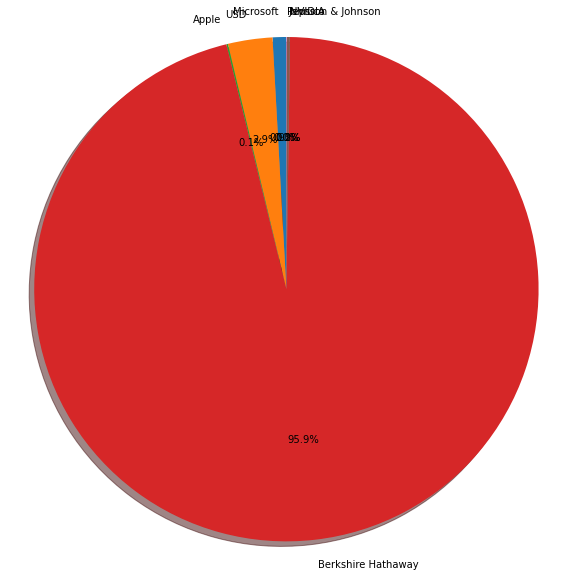

In [66]:
value_and_chart(after_apple_dividend_paid, prices_as_at, accounting_method)

Upon further investigation we realise that our price for Berkshire Hathaway was actually sourced from the price for BRK-A which has a price of `$253,501.00` per share, we hold BRK-B which only has a price of `$169.20` per share, we need to load in a corrected price.

In [67]:
corrected_prices = pd.read_csv("./data/CorrectedPrices.csv")
corrected_prices.head()

,Symbol,Price,Currency,Date
0,EQUITY_APPL,76.9,USD,2020-05-15
1,EQUITY_MSFT,183.2,USD,2020-05-15
2,EQUITY_BRKB,169.2,USD,2020-05-15
3,EQUITY_NVDA,84.9,USD,2020-05-15
4,EQUITY_JNJ,150.4,USD,2020-05-15


In [68]:
response_corrected = CocoonPrinter(load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=corrected_prices,
    mapping_required={
        "quote_id.quote_series_id.provider": "$Lusid",
        "quote_id.quote_series_id.instrument_id": "Symbol",
        "quote_id.quote_series_id.instrument_id_type": "$ClientInternal",
        "quote_id.quote_series_id.quote_type": "$Price",
        "quote_id.quote_series_id.field": "$Close",
        "quote_id.effective_at": "Date",
        "metric_value.value": "Price",
        "metric_value.unit": "Currency"
    },
    mapping_optional={},
    file_type="quotes"
)).format_response()[0]

corrected_prices_as_at = max(response_corrected["as_at"]).to_pydatetime()
response_corrected

,quote_id.quote_series_id.provider,quote_id.quote_series_id.price_source,quote_id.quote_series_id.instrument_id,quote_id.quote_series_id.instrument_id_type,quote_id.quote_series_id.quote_type,quote_id.quote_series_id.field,quote_id.effective_at,metric_value.value,metric_value.unit,lineage,cut_label,uploaded_by,as_at,scale_factor
0,Lusid,None,EQUITY_APPL,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,76.9,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:33.400490+00:00,None
1,Lusid,None,EQUITY_MSFT,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,183.2,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:33.400490+00:00,None
2,Lusid,None,EQUITY_BRKB,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,169.2,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:33.400490+00:00,None
3,Lusid,None,EQUITY_NVDA,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,84.9,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:33.400490+00:00,None
4,Lusid,None,EQUITY_JNJ,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,150.4,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:33.400490+00:00,None
5,Lusid,None,EQUITY_PEP,ClientInternal,Price,Close,2020-05-15T00:00:00.0000000+00:00,135.9,USD,,,00u89xerfkS08fj6e2p7,2023-08-02 02:21:33.400490+00:00,None


Here we can see that with the same effectiveDate of the 15th May 2020 but with an asAt date after the price has been corrected we can produce a more accurate valuation.

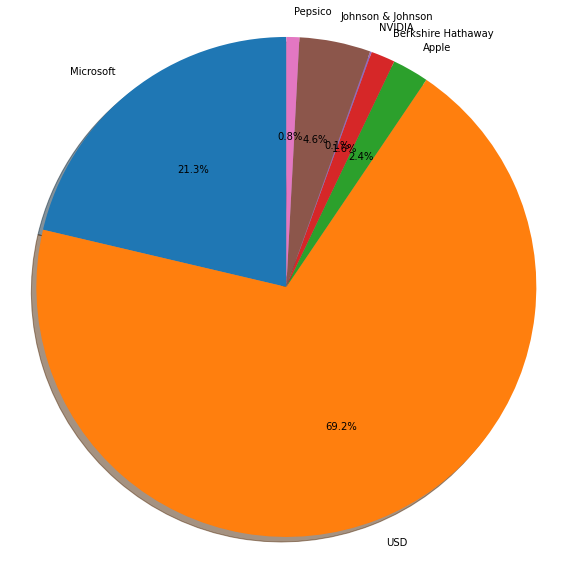

In [69]:
value_and_chart(after_apple_dividend_paid, corrected_prices_as_at, accounting_method)